# Impact of Rain, Temperature and Daylight Hours on the Accident Numbers

This notebook represents the third iteration of this workflow centered on the analysis of weather based factors on the data.

From the previous iteration, we observe that none of the factors (rain, snow, storms) were effectively able to explain the accident numbers. We now study t2 new features - Temperature and Daylight hours, and compare them with the trends for precipitation.

The link to the supplementary datasets can be found in the Readme.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

## First iteration

This code is from the workbook for the first iteration, to enable us to use the same transformations which we used previously, and bring in new transformations as well.

In [2]:
datasets = []
for i in range(2013, 2024):

    file = f"./datasets/crashes_{i}.csv"
    result = pd.read_csv(file)
    result.dropna(subset=['BOROUGH'], inplace=True)
    datasets.append(result)

In [3]:
plt.rcParams['figure.figsize'] = (40,20)

def getPlots(datasets, desc):
    
    for i in range(0, len(datasets)):
        result = datasets[i]
        result["CRASH DATE"] = pd.to_datetime(result["CRASH DATE"])
        result["ACCIDENT_MONTH"] = result["CRASH DATE"].dt.month

        result_grped = result.groupby('ACCIDENT_MONTH').count()['CRASH DATE']

        plt.subplot(3,4,i+1)
        result_grped.plot.bar()
        plt.title(f"Accident numbers per month ({desc})")
        plt.ylabel("Number of accidents")
        
    plt.show()

In [4]:
groupingDictionary_common = {
    "Distraction" : ["Driver Inattention/Distraction", "Outside Car Distraction", "Passenger Distraction", "Glare", "Cell Phone (hand-held)", "Cell Phone (hands-free)", "Other Electronic Device"], 
    "Car Defects" : ["Accelerator Defective", "Brakes Defective", "Headlights Defective", "Other Lighting Defects", "Steering Failure", "Tire Failure/Inadequate", "Tow Hitch Defective", "Windshield Inadequate"],
    "Substance Abuse" : ["Alcohol Involvement", "Drugs (Illegal)", "Prescription Medication"],
    "Driver not at fault" : ["Animals Action", "Lane Marking Improper/Inadequate", "Obstruction/Debris", "Other Vehicular", "Pavement Defective", "Pavement Slippery", "Pedestrian/Bicyclist/Other Pedestrian Error/Confusion", "Reaction to Other Uninvolved Vehicle", "Shoulders Defective/Improper", "Traffic Control Device Improper/Non-Working", "View Obstructed/Limited"], 
    "Driver Inexperience" : ["Driver Inexperience"], 
    "Medical_Fatigue" : ["Fatigued/Drowsy", "Fell Asleep", "Illness", "Lost Consciousness", "Physical Disability"], 
    "Traffic Rule Violation" : ["Aggressive Driving/Road Rage", "Backing Unsafely", "Failure to Keep Right", "Failure to Yield Right-of-Way", "Following Too Closely", "Oversized Vehicle", "Passing Too Closely", "Passing or Lane Usage Improper", "Traffic Control Disregarded", "Turning Improperly", "Unsafe Lane Changing", "Unsafe Speed"]
}
    
def custom_acc_type(row, column):
    for j in groupingDictionary_common.keys():
        if (column == 1):
            if row['CONTRIBUTING FACTOR VEHICLE 1'] in groupingDictionary_common[j]:
                return j

In [5]:
for i in range(len(datasets)):
    datasets[i]['MAJOR ACCIDENT TYPE 1'] = datasets[i].apply(custom_acc_type, column=1 ,axis=1)

## Third iteration

We now begin observing the correlation between the accident numbers and the rainfall, temperature and the daylight hours.

We read the rainfall and temperature data from 3 places in New York City (JFK, La Guardia, and Central Park), and average out the numbers.

In [6]:
rainfall_jfk = pd.read_csv("./datasets/jfk.csv")
rainfall_lg = pd.read_csv("./datasets/LaGuardia.csv")
rainfall_cp = pd.read_csv("./datasets/Central Park.csv")
rainfall_cp

,Date,Value,Anomaly
0,201201,3.23,-0.41
1,201202,1.37,-1.82
2,201203,0.96,-3.33
3,201204,3.56,-0.53
4,201205,5.37,1.41
...,...,...,...
91,201908,3.70,-0.86
92,201909,0.95,-3.36
93,201910,6.16,1.78
94,201911,1.95,-1.63


In [7]:
temp_jfk = pd.read_csv("./datasets/jfk_temp.csv")
temp_lg = pd.read_csv("./datasets/lg_temp.csv")
temp_cp = pd.read_csv("./datasets/cp_temp.csv")
temp_cp

,Date,Value,Anomaly
0,201201,37.8,4.1
1,201202,41.4,5.6
2,201203,51.4,8.6
3,201204,55.3,1.7
4,201205,65.6,2.4
...,...,...,...
91,201908,75.5,-0.5
92,201909,70.4,1.2
93,201910,59.9,2.0
94,201911,43.9,-4.1


In [8]:
rainfall = rainfall_cp
rainfall.drop(columns=['Anomaly'], inplace=True)
rainfall['Value'] = round((rainfall_cp['Value']+rainfall_jfk['Value']+rainfall_lg['Value'])/3, 2)
rainfall

,Date,Value
0,201201,2.64
1,201202,1.32
2,201203,1.03
3,201204,3.24
4,201205,5.71
...,...,...
91,201908,3.33
92,201909,0.90
93,201910,5.48
94,201911,1.70


In [9]:
temp = temp_cp
temp.drop(columns=['Anomaly'], inplace=True)
temp['Value'] = round((temp_cp['Value']+temp_jfk['Value']+temp_lg['Value'])/3, 2)
temp

,Date,Value
0,201201,37.60
1,201202,41.17
2,201203,50.37
3,201204,55.17
4,201205,65.23
...,...,...
91,201908,76.17
92,201909,70.63
93,201910,60.47
94,201911,44.10


We now read the data for the daylight hours. The daylight hours data is present for each day, and we average out the number of hours over the month, to perform analysis.

In [10]:
daylights = []

for j in range(2013, 2020):
    file = f"./datasets/Book_{j}.csv"
    df = pd.read_csv(file)
    
    l = {}

    for i in range(1,13):
        duration = pd.to_datetime(df.iloc[:, i], format="%H:%M").dt.hour*60 + pd.to_datetime(df.iloc[:, i], format="%H:%M").dt.minute
        dic = {'Date':j*100+i, 'Value': int(duration.mean())}
        daylights.append(dic)

daylights = pd.DataFrame(daylights)
daylights

,Date,Value
0,201301,579
1,201302,641
2,201303,718
3,201304,799
4,201305,867
...,...,...
79,201908,824
80,201909,747
81,201910,667
82,201911,596


We now move on to the main transformation step. Equipped with the monthly data of rainfall, temperature and daylight hours, we create a new dataframe where we count the accident numbers for the given year and month, and then we combine all the data to get monthly data for each of the factors. 

This is observed in the getTransformedDataFrame() function, which takes a list of datasets for each year, and gives us the required data.

In [11]:
def getTransformedDataFrame(datasets):
    dataset = []
    for i in range(2013, 2020):
    
        result = datasets[i-2013]
        result.dropna(subset=['BOROUGH'], inplace=True)
        
        result["CRASH DATE"] = pd.to_datetime(result["CRASH DATE"])
        result["ACCIDENT_MONTH"] = result["CRASH DATE"].dt.month

        result_grped = result.groupby('ACCIDENT_MONTH').count()['CRASH DATE']

        for j in range(1,13):
            dictionary = {'Year':i, 'Month':j, 'Accidents':result_grped[j], 'Precipitation': rainfall.loc[rainfall['Date'] == 100*i+j].iloc[0]['Value'], 
                        'Temperature':temp.loc[temp['Date'] == 100*i+j].iloc[0]['Value'], 'Daylight':daylights.loc[daylights['Date'] == 100*i+j].iloc[0]['Value']}  
            dataset.append(dictionary)

    transformed_df = pd.DataFrame(dataset)
    return transformed_df

In [12]:
transformed_df = getTransformedDataFrame(datasets)
transformed_df

,Year,Month,Accidents,Precipitation,Temperature,Daylight
0,2013,1,11979,2.60,35.60,579
1,2013,2,11247,3.40,34.43,641
2,2013,3,12810,2.55,40.50,718
3,2013,4,12712,1.42,52.40,799
4,2013,5,14337,5.68,62.37,867
...,...,...,...,...,...,...
79,2019,8,11132,3.33,76.17,824
80,2019,9,11409,0.90,70.63,747
81,2019,10,11265,5.48,60.47,667
82,2019,11,11079,1.70,44.10,596


Equipped with the transformed data, we observe the correlation values between the accident numbers and the weather parameters. The conclusions have been explained in detail in the report.

In [13]:
def getDualPlot(df_to_plot, column, year, type):
    plt.rcParams['figure.figsize'] = (8,4)
    fig, ax = plt.subplots()

    ax.bar(df_to_plot['Month'], df_to_plot['Accidents'])

    ax2 = ax.twinx()
    ax2.plot(df_to_plot['Month'], df_to_plot[column], color='k', marker='o')
    ax2.set_ylabel(column)

    plt.savefig(f"./images/second/{type}_{column}_{year}.png")
    plt.show()

Year - 2013
0.4546577084604513
0.5339582587066065
0.4781428213638841


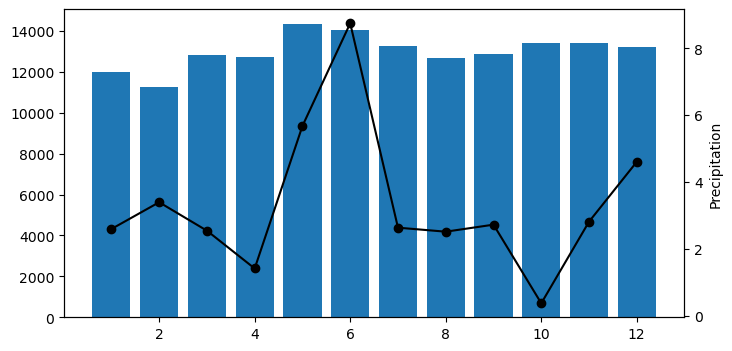

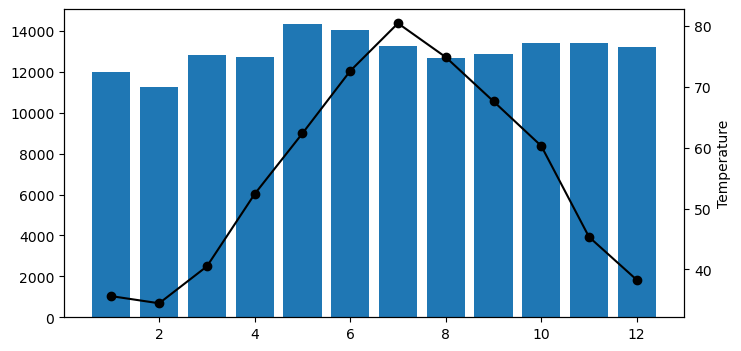

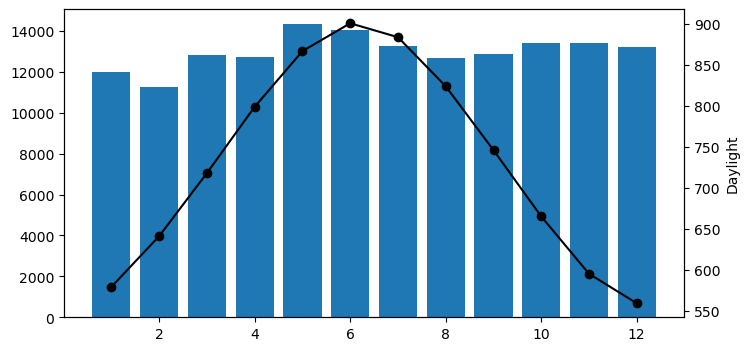

Year - 2014
-0.3204701747545821
0.686560119382722
0.4007662217819287


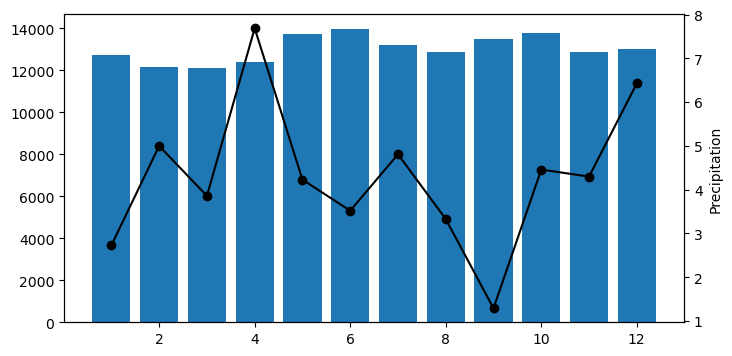

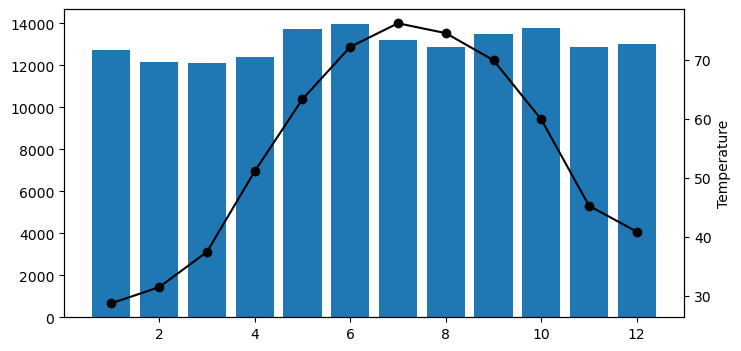

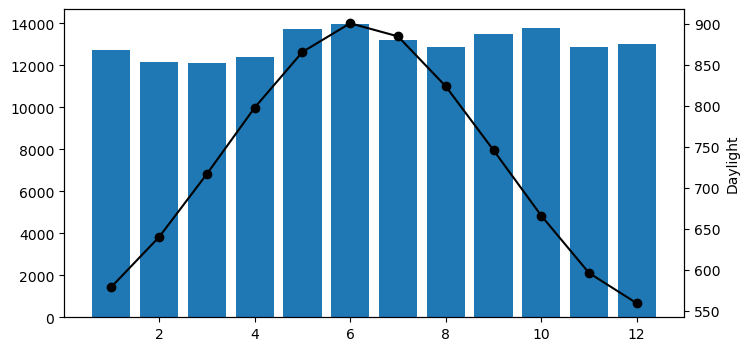

Year - 2015
0.13037009246379044
0.7316800892213952
0.34544744354149076


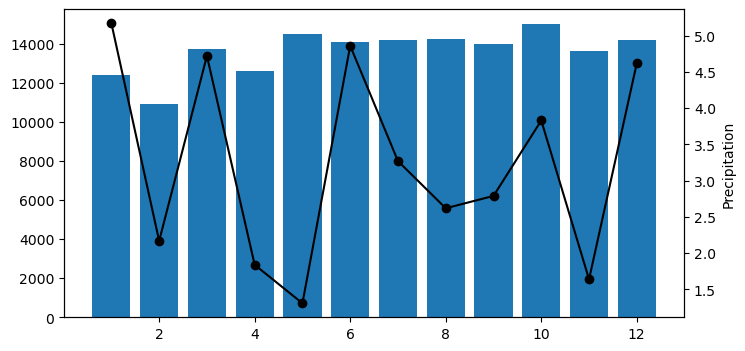

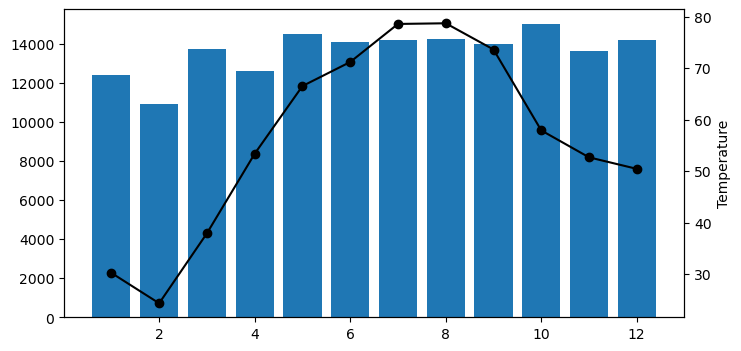

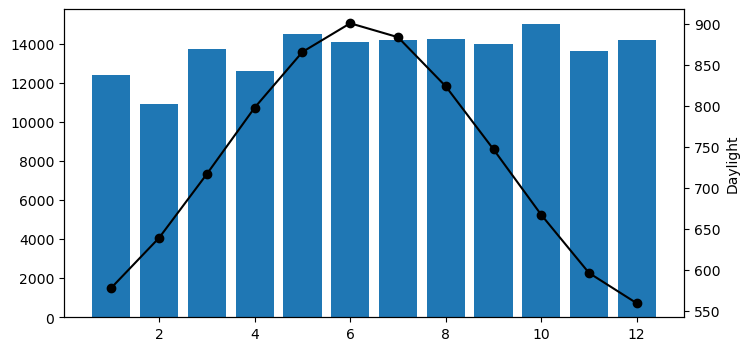

Year - 2016
0.10051308578791764
0.012776674056908794
0.4117139973729996


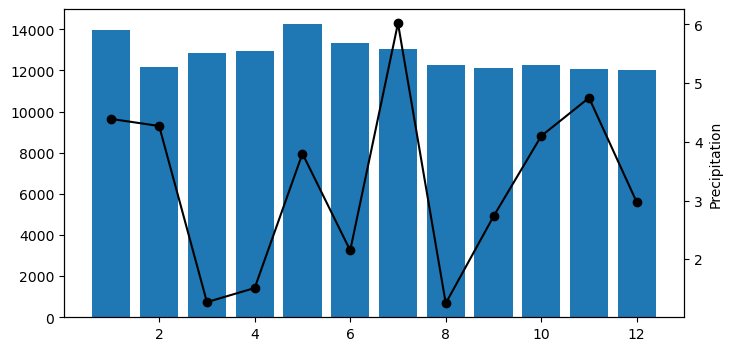

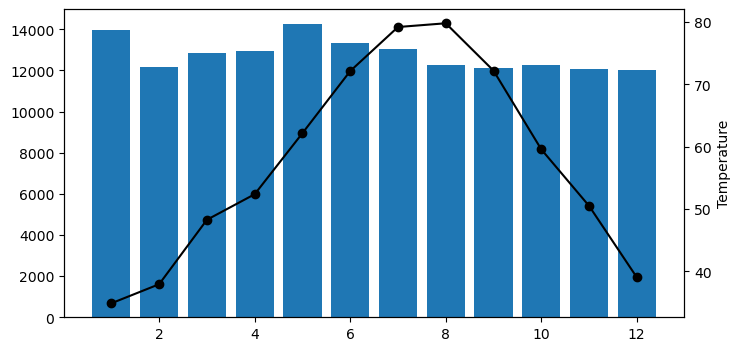

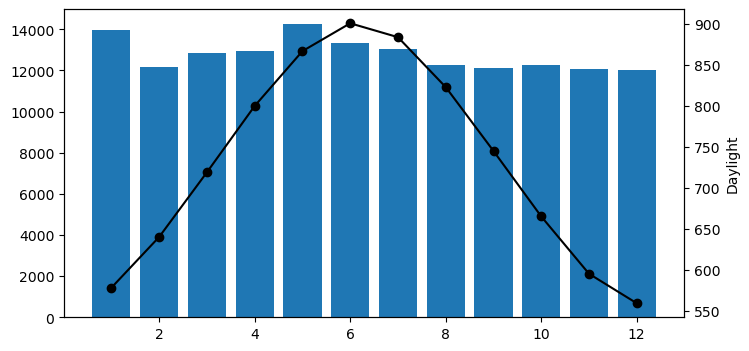

Year - 2017
0.4515321790367224
0.2163162435932823
0.4187806308493553


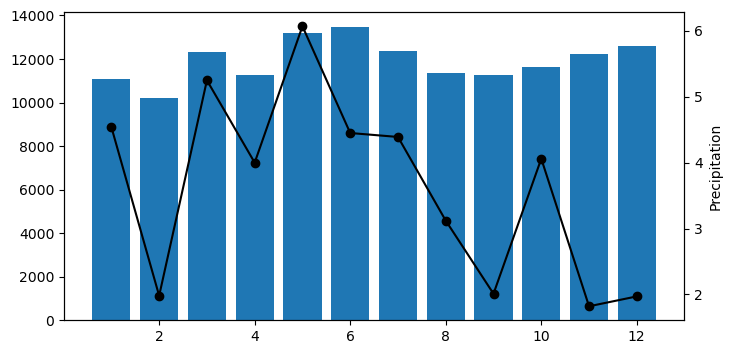

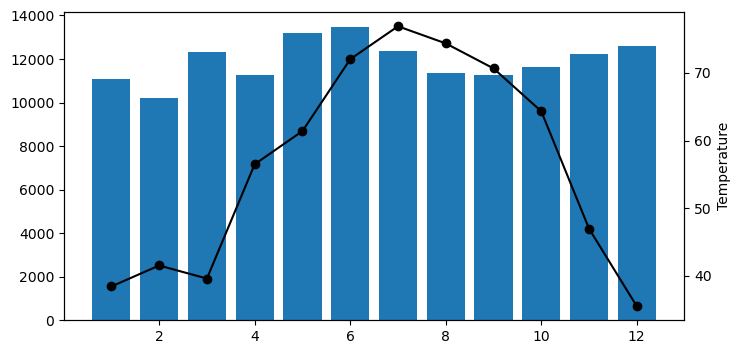

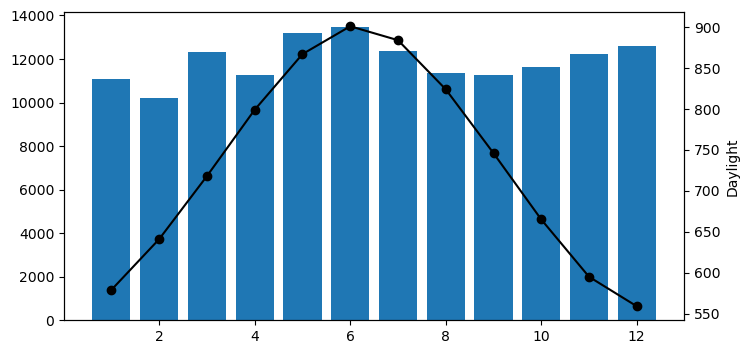

Year - 2018
-0.19186309268451623
0.5628329723171775
0.45704807426151833


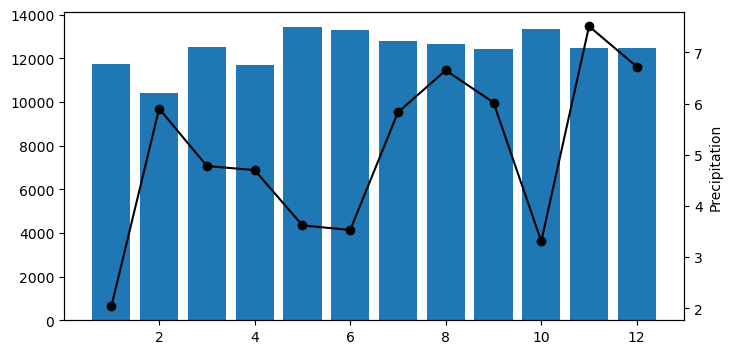

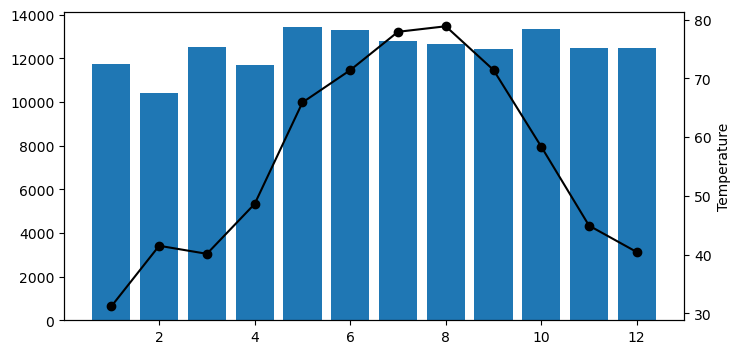

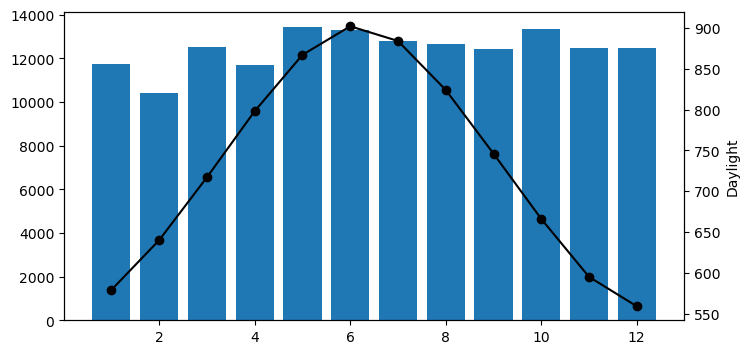

Year - 2019
0.4175562666823352
0.5722216033424102
0.6967194630225572


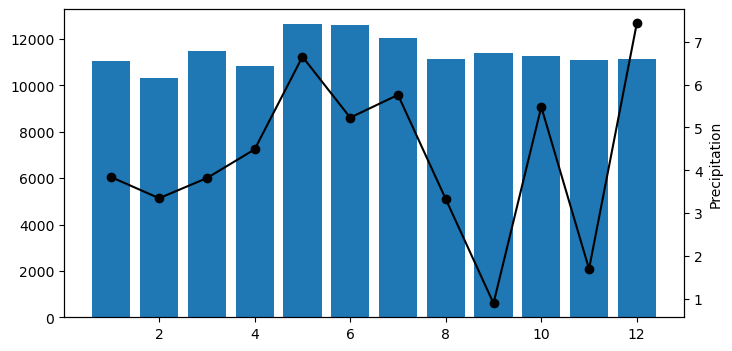

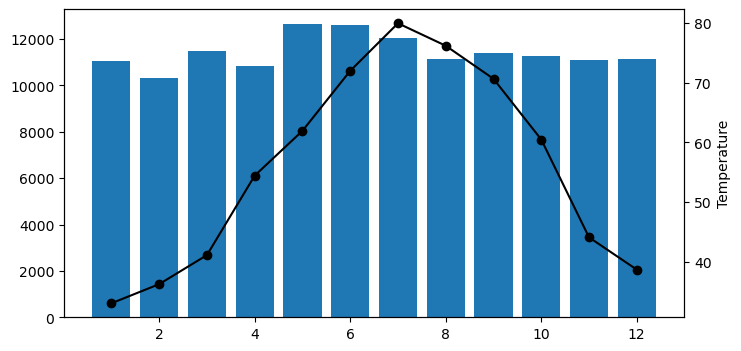

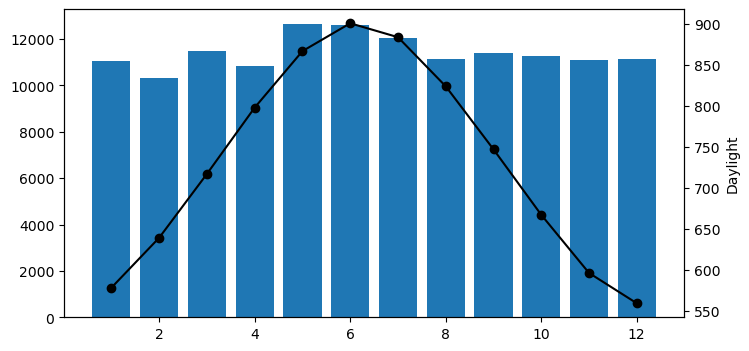

In [14]:
for i in range(0,73,12):
    print("Year - "+str(2013+(i//12)))
    print(transformed_df['Accidents'][i:i+12].corr(transformed_df['Precipitation'][i:i+12]))
    print(transformed_df['Accidents'][i:i+12].corr(transformed_df['Temperature'][i:i+12]))
    print(transformed_df['Accidents'][i:i+12].corr(transformed_df['Daylight'][i:i+12]))
    
    df_to_plot = transformed_df.loc[:, "Month":"Daylight"][i:i+12]
    
    getDualPlot(df_to_plot, "Precipitation", 2013+(i//12), "Total")
    getDualPlot(df_to_plot, "Temperature", 2013+(i//12), "Total")
    getDualPlot(df_to_plot, "Daylight", 2013+(i//12), "Total")

We conclude overall that the daylight hours and the temperature are good indicators for the trends of various accident types. A supplementary analysis is performed on the time of the day as well, to see whether these factors can also explan the distribution with regards to time.